# Start

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

# data preprocessing
import pandas_ta as ta
from time_series_utils import df_apply_indicator, series_crossover, series_crossunder, rr_order_block, make_lags

# model training
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# functional tools
from tqdm import tqdm
import logging
logging.getLogger().setLevel(logging.INFO)


In [2]:
# import BTCUSDT data
ohlc_file_path, asset_pair = r'.\backtest_data\BTCUSDT_1m.csv', 'BTCUSDT'
bar_info = pd.read_csv(ohlc_file_path, index_col=0, parse_dates=True)

In [3]:
# resample high to 60 minutes
ohlcv_agg = dict((
    ('Open', 'first'),
    ('High', 'max'),
    ('Low', 'min'),
    ('Close', 'last'),
    ('Volume', 'sum'),
    ))

# X Feature

In [4]:
X = bar_info.copy()
X = X.resample('5 min').agg(ohlcv_agg)
X = X.interpolate(method='linear')

<Axes: >

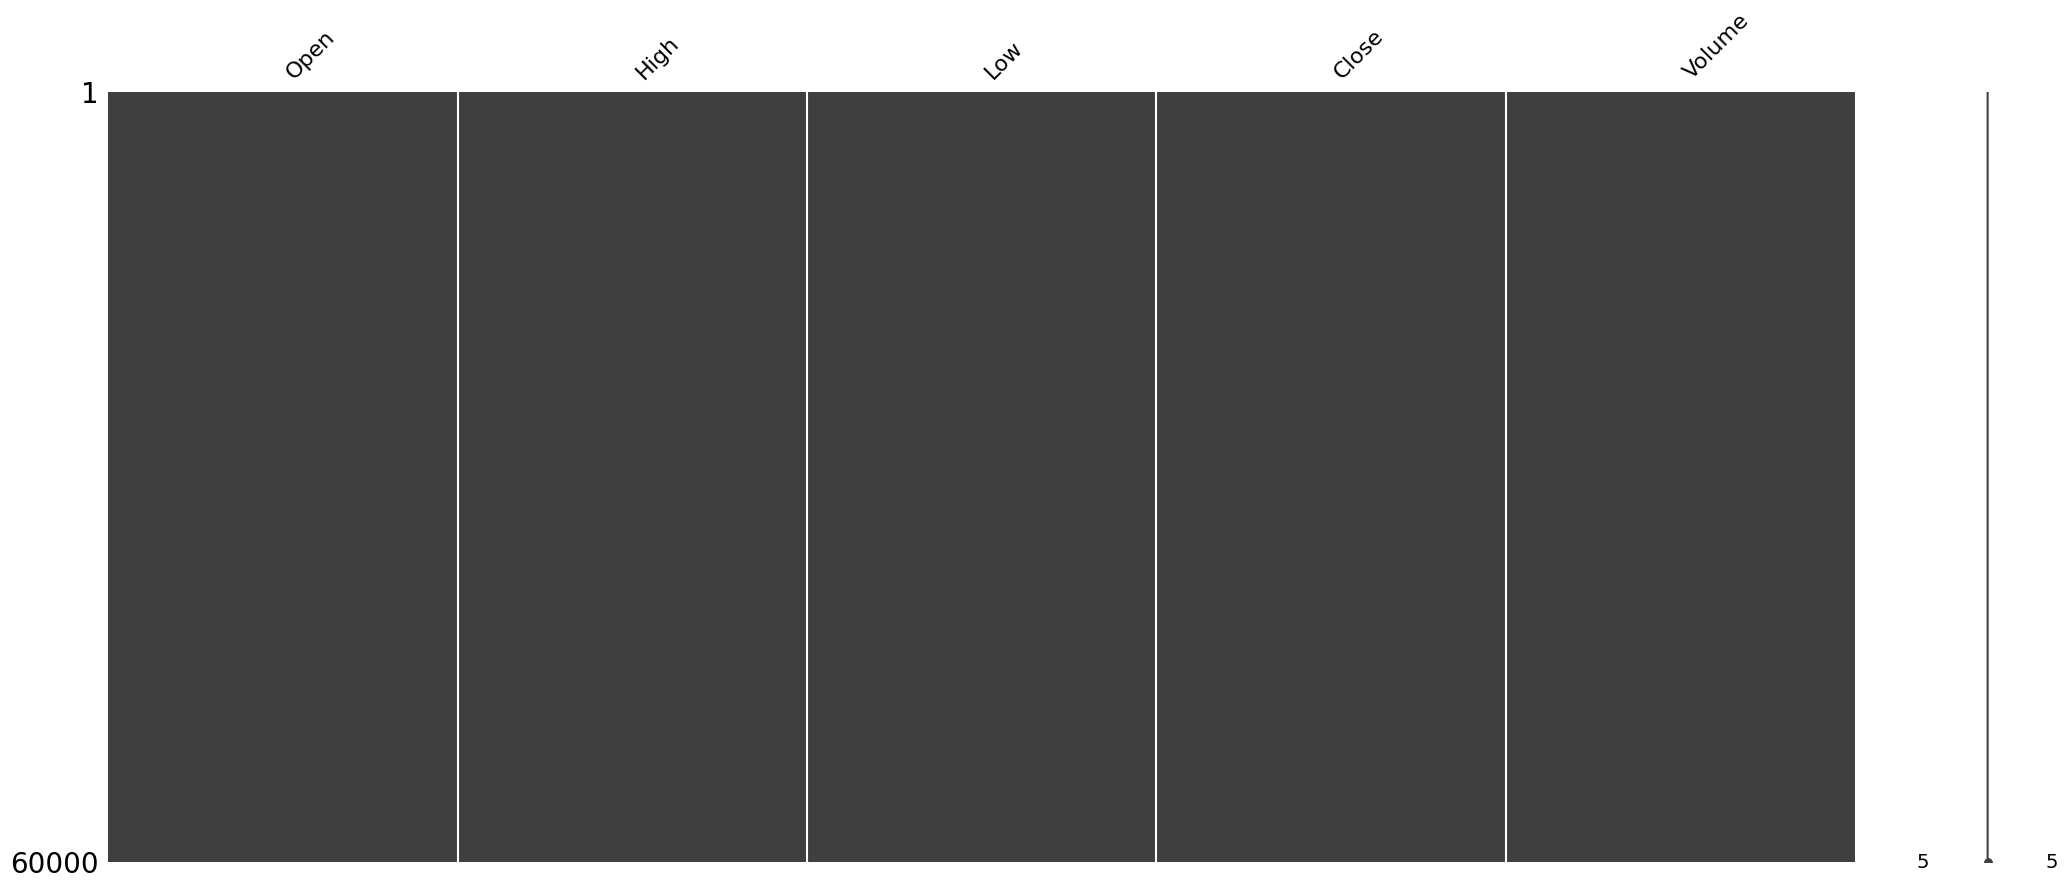

In [6]:
msno.matrix(X)

## Add ta indicators to DF

In [7]:
def df_apply_indicator(df, indicator, args=None, kwargs=None, resample_period='5T'):
    '''resample to "resample_period", apply "indicator" passed in parameters and upsample to original frequency'''
    initial_freq = df.index.freq
    original_columns = df.columns.tolist()

    # resample to resample_period
    df = df.resample(resample_period).agg(ohlcv_agg)
    print(df.index.freq)
    
    # apply indicator function to dataframe
    df = indicator(df, *args, **kwargs)
    df.drop(original_columns, axis=1, inplace=True)
    
    # resample to original frequency and set timestamp to candle close
    df = df.shift(1).resample(initial_freq).ffill()
    df.columns = df.columns + '_' + resample_period
    
    return df

In [8]:
def df_resample_strategy(df, strat, resample_period='5T', *args, **kwargs):
    '''resample to "resample_period", apply "indicator" passed in parameters and upsample to original frequency'''
    initial_freq = df.index.freq
    original_columns = df.columns.tolist()

    # resample to resample_period
    df = df.resample(resample_period).agg(ohlcv_agg)
    print(df.index.freq)
    
    # apply indicator function to dataframe
    ta.DataFrame.ta.strategy(df.ta, strat, *args, **kwargs)
    df.drop(original_columns, axis=1, inplace=True)
    
    # resample to original frequency and set timestamp to candle close
    df = df.shift(1).resample(initial_freq).ffill()
    df.columns = df.columns + '_' + resample_period
    
    return df

In [9]:
def series_apply_indicator(func, params, resample_period='5T'):
    '''resample to "resample_period", apply indicator passed in parameters and upsample to original frequency'''
    for key, series in params.items():
        try:
            if series.index.freq is None:
                raise ValueError(f"Series {key} has no frequency set")
        except Exception as e:
            print(e, series)
            continue

        initial_freq = series.index.freq
        
        # resample to resample_period
        params[key] = series.resample(resample_period).agg(ohlcv_agg[series.name])

    # apply indicator function to dataframe
    indicator_series = func(**params)
    
    # resample to original frequency and set timestamp to candle close
    indicator_series = indicator_series.shift(1).resample(initial_freq).ffill()
    indicator_series.name = indicator_series.name + '_' + resample_period

    return indicator_series

In [10]:
ContextStrategy = ta.Strategy(name="ContextStrategy"
            , description="context indicators"
            , ta=[
                {"kind": "inertia", "length":40, "rvi_length": 20}, 
                {"kind": "slope"},
                {"kind": "smi"},
                {"kind": "pvi"}
                ]
            )

In [13]:
# add market context in longer timeframes
resample_period = '60T'
df_temp = df_resample_strategy(X, ContextStrategy, resample_period=resample_period)
X = X.merge(df_temp, left_index=True, right_index=True, how='left')

X.columns.str.contains('_'+resample_period)

## fillforward last candle
X.iloc[:,X.columns.str.contains('_'+resample_period)] = X.iloc[:,X.columns.str.contains('_'+resample_period)].fillna(method='ffill')
X.shape

<60 * Minutes>


(60000, 11)

(60000, 11)


<Axes: >

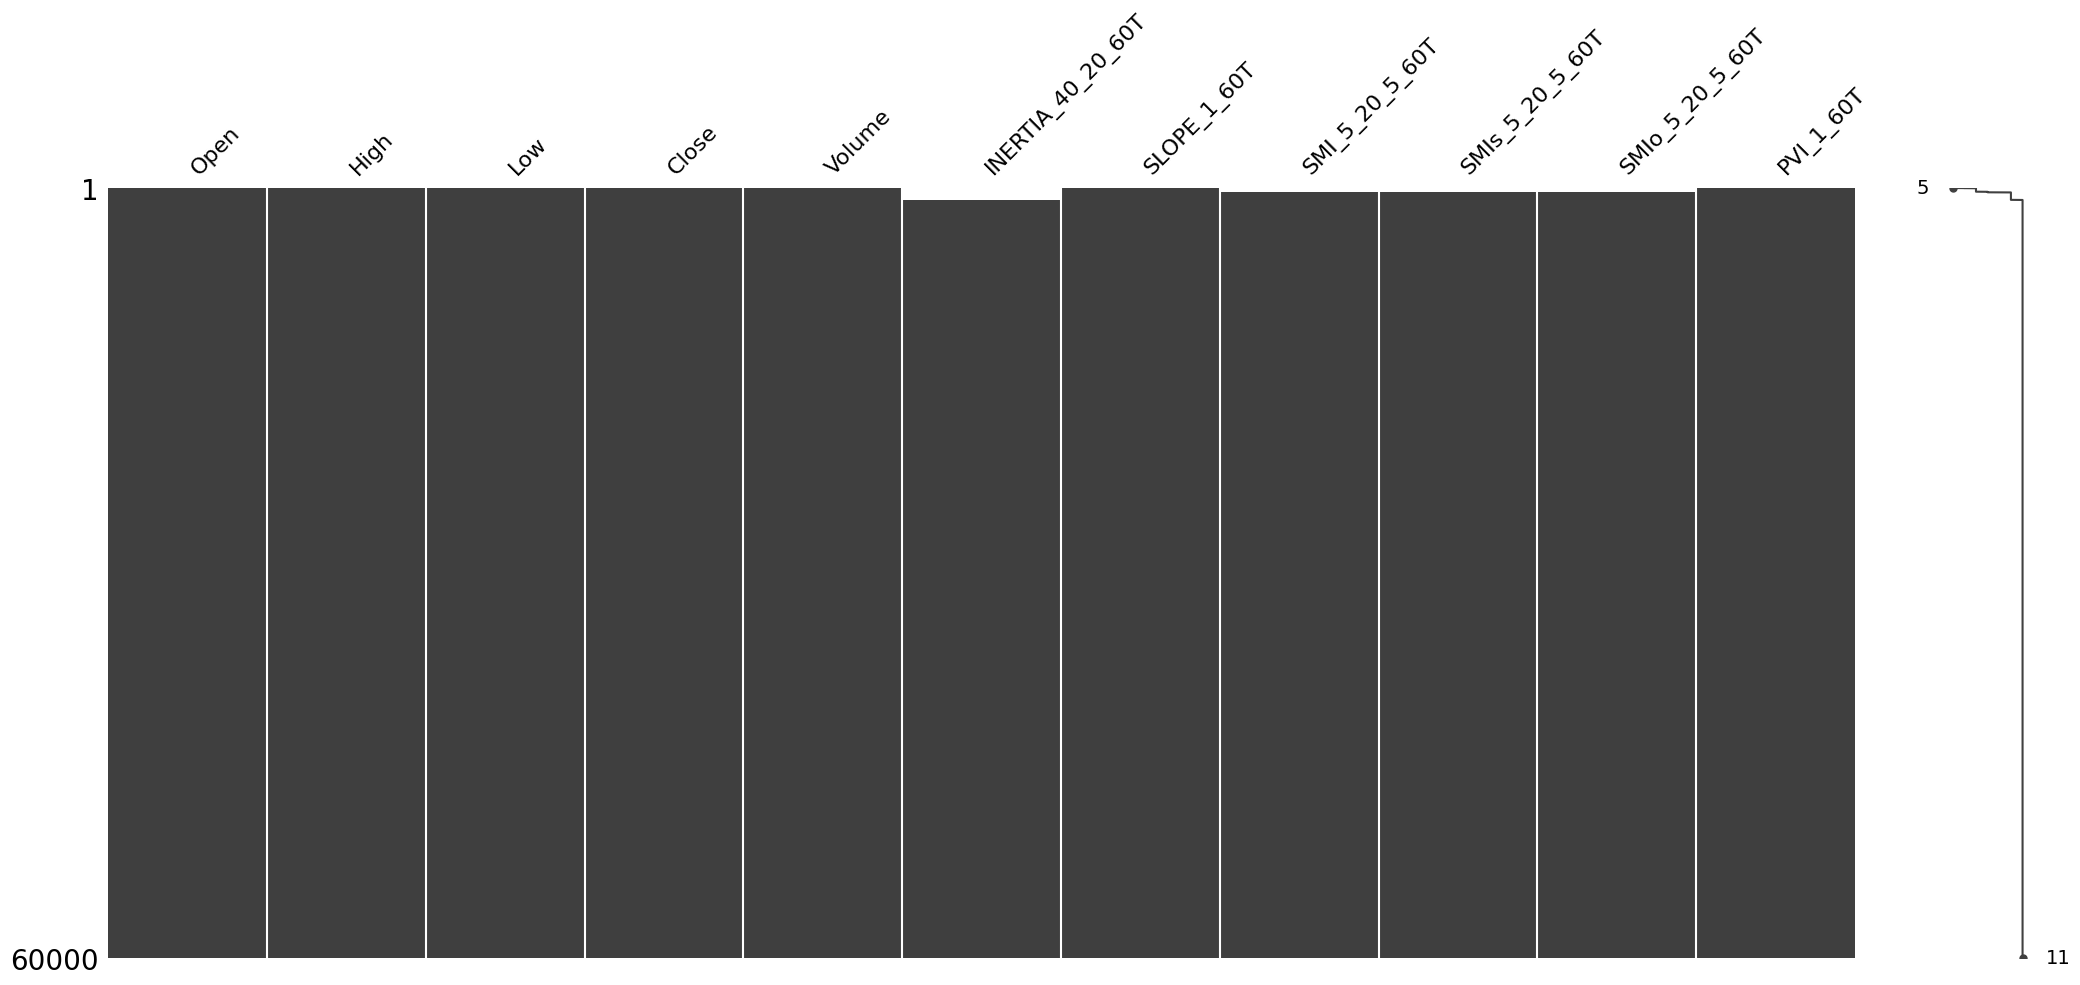

In [14]:
print(X.shape)
msno.matrix(X)

## Interpreted indicators

In [15]:
# replace substrings in series with values in dictionary
def replace_substrings(series, substrings_dict):
    for key, value in substrings_dict.items():
        series = series.str.replace(key, value)
    return series

In [16]:
for category in X.ta.categories:
    if category == 'candles':
        continue
    else:
        print(category)
    X.ta.strategy(category, prefix=category)


X.columns = replace_substrings(X.columns.to_series(),dict(zip(pd.Series(X.ta.categories)+"_"+pd.Series(X.ta.categories), pd.Series(X.ta.categories)))).values
X.shape

cycles


1it [00:02,  2.20s/it]


momentum


39it [00:22,  1.76it/s]


overlap


32it [00:25,  1.26it/s]


performance


2it [00:01,  1.42it/s]


statistics


10it [00:03,  2.65it/s]


trend


14it [00:12,  1.10it/s]


volatility


14it [00:04,  3.00it/s]


volume


14it [00:04,  3.10it/s]


(60000, 218)

In [17]:
# drop columns that leak future data (https://github.com/twopirllc/pandas-ta/issues/60)
X.drop(columns=['trend_DPO_20', 'overlap_ICS_26'], inplace=True)

(60000, 216)


<Axes: >

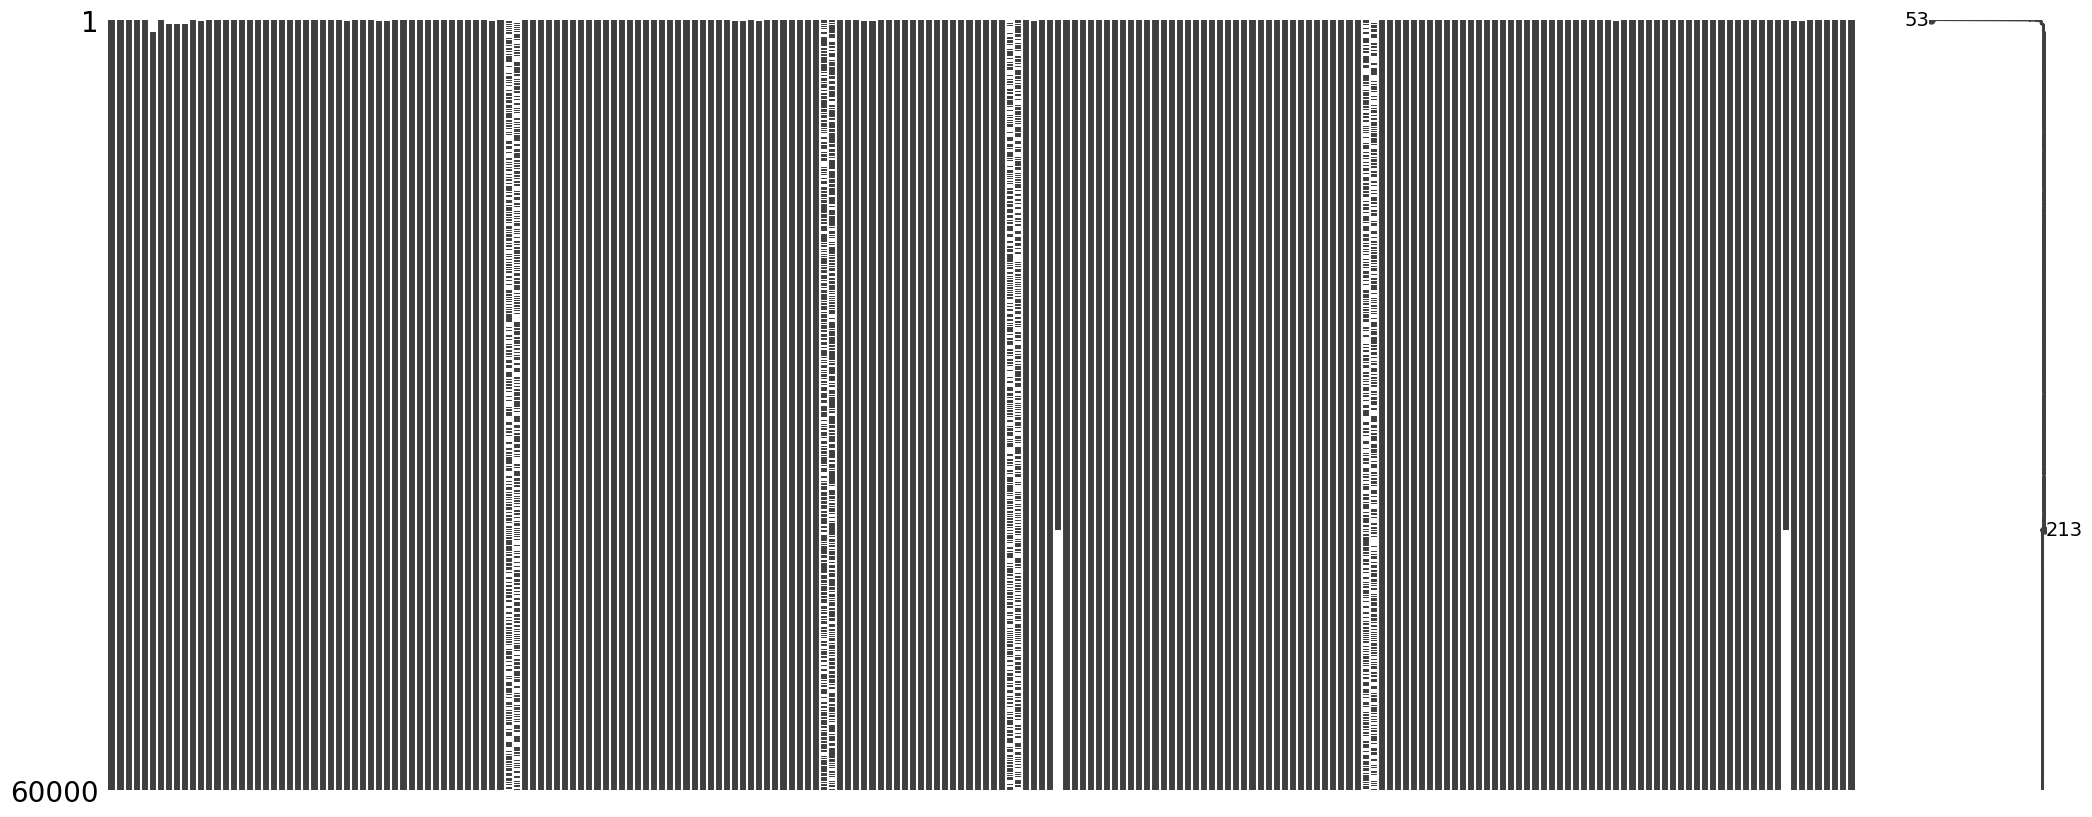

In [18]:
print(X.shape)
msno.matrix(X)

In [19]:
# keep columns with less than 10% of NaN values
X = X.iloc[:,(X.apply(pd.Series.isna).sum() / X.shape[0] < 0.1).values].copy()
# drop columns with infinite values
X = X.iloc[:,((X == np.inf).sum()<1).values].copy()

X.shape

(60000, 204)

(60000, 204)


<Axes: >

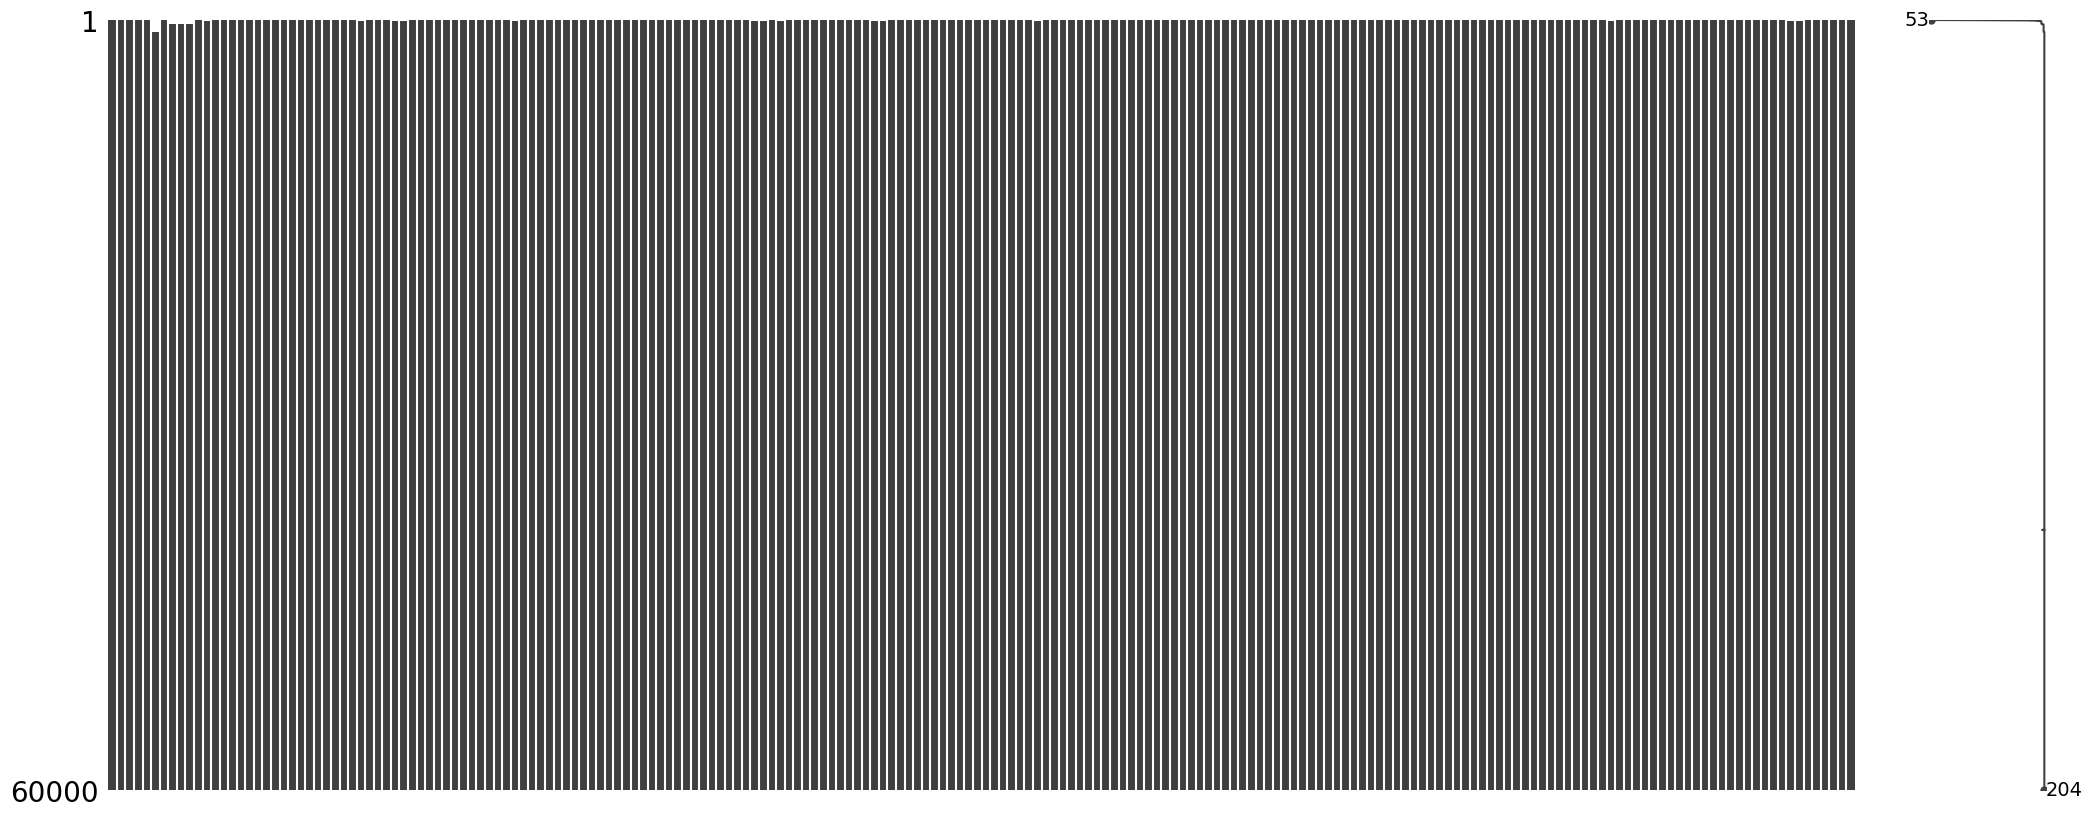

In [20]:
print(X.shape)
msno.matrix(X)

# Y feature

## Y predicted

In [21]:
# predict potential fixed profit in the next 20 candles 
y = rr_order_block(X['Close'], X['High'], X['Low'], risk=0.01, ratio=3, lead=20, ob_type='buy')
print(y.shape)
print((y).value_counts())
y_labels = ['undetermined', 'loss', 'profit']


(60000,)
0.0    48405
1.0    10489
2.0     1106
dtype: int64


In [22]:
# predict inertia bins
y_bins = [-np.inf]+[i for i in range(30, 55, 5)]+[i for i in range(55, 70, 5)]+[np.inf]
y = pd.cut(ta.momentum.inertia(X['Close']), bins=y_bins).shift(-10)
print(y.value_counts().sort_index())
# convert intervalindex to str labels
y_labels = [str(i) for i in pd.Categorical(y).categories]
y = pd.Series(pd.Categorical(y).codes, index=y.index).replace(-1, np.nan)

(-inf, 30.0]     1832
(30.0, 35.0]     2762
(35.0, 40.0]     5142
(40.0, 45.0]     8317
(45.0, 50.0]    11470
(50.0, 55.0]    11444
(55.0, 60.0]     8914
(60.0, 65.0]     5337
(65.0, inf]      4737
Name: INERTIA_20_14, dtype: int64


<BarContainer object of 1000 artists>

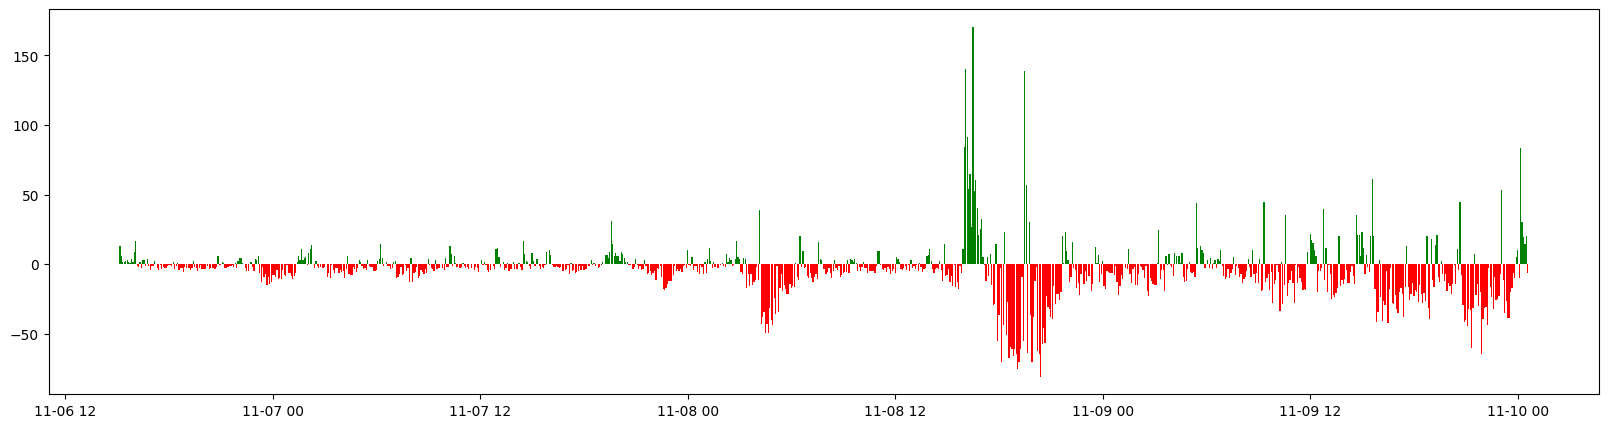

In [36]:
y = X.ta.ema(22) + X.ta.atr(length=13, append=False)*3
y = y - y.shift(1)

# barplot for y, x axis is y index. make color green if y is positive, red if negative
plt.figure(figsize=(20,5))
candles = 1000
plt.bar(y.iloc[:candles].index, y.iloc[:candles].values, width=0.003, color=np.where(y.iloc[:candles].values>0, 'g', 'r'))

# Train Test Split

In [24]:
# drop rows with NaN values in y that come from shifting the series
y = y.dropna()
X=X.loc[y.index]
X = X.dropna()
y=y.loc[X.index]

## Scale features

In [25]:
X_transformed = X.copy()

In [26]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Identify categorical and continuous columns and set(X[col].unique()).issubset({-1, 0, 1})
categorical_columns = [col for col in X.columns if X[col].nunique() <= 100 ]
continuous_columns = [col for col in X.columns if col not in categorical_columns]

In [27]:
# scale continuous variables
scaler = StandardScaler()
X_transformed[continuous_columns] = scaler.fit_transform(X_transformed[continuous_columns])

print(X_transformed.shape)
X_transformed.head()

(72260, 207)


,Open,High,Low,Close,Volume,INERTIA_40_20_60T,SLOPE_1_60T,SMI_5_20_5_60T,SMIs_5_20_5_60T,SMIo_5_20_5_60T,PVI_1_60T,cycles_EBSW_40_10,momentum_AO_5_34,momentum_APO_12_26,momentum_BIAS_SMA_26,momentum_BOP,momentum_AR_26,momentum_BR_26,momentum_CCI_14_0.015,momentum_CFO_9,momentum_CG_10,momentum_CMO_14,momentum_COPC_11_14_10,momentum_CTI_12,momentum_ER_10,momentum_BULLP_13,momentum_BEARP_13,momentum_FISHERT_9_1,momentum_FISHERTs_9_1,momentum_INERTIA_20_14,momentum_K_9_3,momentum_D_9_3,momentum_J_9_3,momentum_KST_10_15_20_30_10_10_10_15,momentum_KSTs_9,momentum_MACD_12_26_9,momentum_MACDh_12_26_9,momentum_MACDs_12_26_9,momentum_MOM_10,momentum_PGO_14,momentum_PPO_12_26_9,momentum_PPOh_12_26_9,momentum_PPOs_12_26_9,momentum_PSL_12,momentum_PVO_12_26_9,momentum_PVOh_12_26_9,momentum_PVOs_12_26_9,momentum_QQE_14_5_4.236,momentum_QQE_14_5_4.236_RSIMA,momentum_ROC_10,momentum_RSI_14,momentum_RSX_14,momentum_RVGI_14_4,momentum_RVGIs_14_4,momentum_SLOPE_1,momentum_SMI_5_20_5,momentum_SMIs_5_20_5,momentum_SMIo_5_20_5,momentum_SQZ_20_2.0_20_1.5,momentum_SQZ_ON,momentum_SQZ_OFF,momentum_SQZ_NO,momentum_SQZPRO_20_2.0_20_2_1.5_1,momentum_SQZPRO_ON_WIDE,momentum_SQZPRO_ON_NORMAL,momentum_SQZPRO_ON_NARROW,momentum_SQZPRO_OFF,momentum_SQZPRO_NO,momentum_STC_10_12_26_0.5,momentum_STCmacd_10_12_26_0.5,momentum_STCstoch_10_12_26_0.5,momentum_STOCHk_14_3_3,momentum_STOCHd_14_3_3,momentum_STOCHRSIk_14_14_3_3,momentum_STOCHRSId_14_14_3_3,momentum_TRIX_30_9,momentum_TRIXs_30_9,momentum_TSI_13_25_13,momentum_TSIs_13_25_13,momentum_UO_7_14_28,momentum_WILLR_14,overlap_ALMA_10_6.0_0.85,overlap_DEMA_10,overlap_EMA_10,overlap_FWMA_10,overlap_HILO_13_21,overlap_HL2,overlap_HLC3,overlap_HMA_10,overlap_ISA_9,overlap_ISB_26,overlap_ITS_9,overlap_IKS_26,overlap_JMA_7_0,overlap_KAMA_10_2_30,overlap_LR_14,overlap_MCGD_10,overlap_MIDPOINT_2,overlap_MIDPRICE_2,overlap_OHLC4,overlap_PWMA_10,overlap_RMA_10,overlap_SINWMA_14,overlap_SMA_10,overlap_SSF_10_2,overlap_SUPERT_7_3.0,overlap_SUPERTd_7_3.0,overlap_SWMA_10,overlap_T3_10_0.7,overlap_TEMA_10,overlap_TRIMA_10,overlap_VIDYA_14,overlap_VWAP_D,overlap_VWMA_10,overlap_WCP,overlap_WMA_10,overlap_ZL_EMA_10,performance_LOGRET_1,performance_PCTRET_1,statistics_ENTP_10,statistics_KURT_30,statistics_MAD_30,statistics_MEDIAN_30,statistics_QTL_30_0.5,statistics_SKEW_30,statistics_STDEV_30,statistics_TOS_STDEVALL_LR,statistics_TOS_STDEVALL_L_1,statistics_TOS_STDEVALL_U_1,statistics_TOS_STDEVALL_L_2,statistics_TOS_STDEVALL_U_2,statistics_TOS_STDEVALL_L_3,statistics_TOS_STDEVALL_U_3,statistics_VAR_30,statistics_ZS_30,trend_ADX_14,trend_DMP_14,trend_DMN_14,trend_AMATe_LR_8_21_2,trend_AMATe_SR_8_21_2,trend_AROOND_14,trend_AROONU_14,trend_AROONOSC_14,trend_CHOP_14_1_100,trend_CKSPl_10_3_20,trend_CKSPs_10_3_20,trend_LDECAY_5,trend_DEC_1,trend_INC_1,trend_PSARaf_0.02_0.2,trend_PSARr_0.02_0.2,trend_QS_10,trend_TTM_TRND_6,trend_VHF_28,trend_VTXP_14,trend_VTXM_14,volatility_ABER_ZG_5_15,volatility_ABER_SG_5_15,volatility_ABER_XG_5_15,volatility_ABER_ATR_5_15,volatility_ACCBL_20,volatility_ACCBM_20,volatility_ACCBU_20,volatility_ATRr_14,volatility_BBL_5_2.0,volatility_BBM_5_2.0,volatility_BBU_5_2.0,volatility_BBB_5_2.0,volatility_BBP_5_2.0,volatility_DCL_20_20,volatility_DCM_20_20,volatility_DCU_20_20,volatility_HWM,volatility_HWU,volatility_HWL,volatility_KCLe_20_2,volatility_KCBe_20_2,volatility_KCUe_20_2,volatility_MASSI_9_25,volatility_NATR_14,volatility_PDIST,volatility_RVI_14,volatility_THERMO_20_2_0.5,volatility_THERMOma_20_2_0.5,volatility_THERMOl_20_2_0.5,volatility_THERMOs_20_2_0.5,volatility_TRUERANGE_1,volatility_UI_14,volume_AD,volume_ADOSC_3_10,volume_OBV,volume_OBV_min_2,volume_OBV_max_2,volume_OBVe_4,volume_OBVe_12,volume_AOBV_LR_2,volume_AOBV_SR_2,volume_CMF_20,volume_EFI_13,volume_KVO_34_55_13,volume_KVOs_34_55_13,volume_MFI_14,volume_NVI_1,volume_PVI_1,volume_PVOL,volume_PVR,volume_PVT
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

# MODELS

## LGBM Regressor MODEL

In [28]:
# for 2nd run when we focus on only the top features
try:
    columns_of_interest = top_features
        # raise
except:
    columns_of_interest = X_transformed.columns
columns_of_interest

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'INERTIA_40_20_60T',
       'SLOPE_1_60T', 'SMI_5_20_5_60T', 'SMIs_5_20_5_60T', 'SMIo_5_20_5_60T',
       ...
       'volume_CMF_20', 'volume_EFI_13', 'volume_KVO_34_55_13',
       'volume_KVOs_34_55_13', 'volume_MFI_14', 'volume_NVI_1', 'volume_PVI_1',
       'volume_PVOL', 'volume_PVR', 'volume_PVT'],
      dtype='object', length=207)

In [29]:
# make lags for all desired variables 3rd run

for col in tqdm(columns_of_interest):
    # X_transformed = X_transformed.merge(make_lags(X_transformed[col], 10, name=col), left_index=True, right_index=True)
    pass

X_transformed.shape

100%|██████████| 207/207 [00:00<?, ?it/s]


(72260, 207)

In [37]:
# split into train and test datasets. Set shuffle to false to avoid data leakage

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed.loc[:,X_transformed.columns.str.contains('|'.join(columns_of_interest), regex=True)]
    , y
    , test_size=0.2
    , shuffle=False)

In [38]:
# Create a LightGBM data matrix from the training set
lgb_train = lgb.Dataset(X_train.reset_index(drop=True), label=y_train.reset_index(drop=True), categorical_feature=categorical_columns)

In [39]:
X_train.shape, y_train.shape, lgb_train.data.shape

((57808, 207), (57808,), (57808, 207))

c:\Users\juanm\anaconda3\envs\bcs-trade-bot\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033138 seconds.
You can set `force_col_wise=true` to remove the overhead.


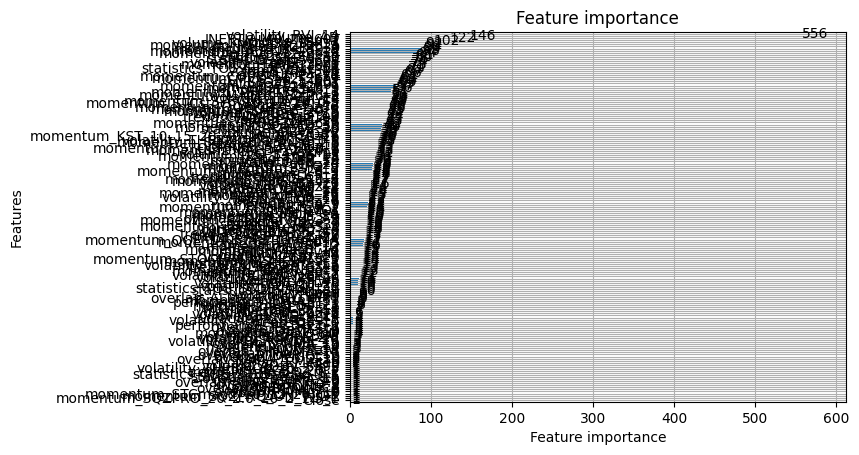

In [40]:
lgb_train = lgb.Dataset(X_train.reset_index(drop=True), label=y_train.reset_index(drop=True), categorical_feature=X_train.columns[X_train.columns.str.contains('k_crossover_d') | X_train.columns.str.contains('k_crossunder_d')].to_list())


# Specify the configuration of the model
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(y_labels),
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

# Train the model
model = lgb.train(params,
                lgb_train,
                num_boost_round=20)

# Predict on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

# Plotting feature importances
lgb.plot_importance(model)
plt.show()

### metrics

In [35]:
# top_features = pd.Series(model.feature_importance(), X_train.columns).sort_values(ascending=False).head(30).index.values
# top_features

array(['volatility_RVI_14', 'volume_AD', 'INERTIA_40_20_60T',
       'volume_NVI_1', 'momentum_PVOh_12_26_9', 'volume_KVOs_34_55_13',
       'statistics_KURT_30', 'momentum_TRIXs_30_9',
       'momentum_INERTIA_20_14', 'momentum_PVO_12_26_9',
       'statistics_ZS_30', 'statistics_SKEW_30', 'SMIs_5_20_5_60T',
       'volatility_MASSI_9_25', 'momentum_TRIX_30_9', 'PVI_1_60T',
       'statistics_TOS_STDEVALL_LR', 'volume_CMF_20', 'trend_ADX_14',
       'volume_PVT', 'momentum_COPC_11_14_10', 'momentum_PVOs_12_26_9',
       'SMI_5_20_5_60T', 'SLOPE_1_60T', 'SMIo_5_20_5_60T',
       'momentum_PPO_12_26_9', 'momentum_KSTs_9',
       'momentum_TSIs_13_25_13', 'volume_PVI_1', 'momentum_MACDs_12_26_9'],
      dtype=object)

In [36]:
pd.Series(model.feature_importance(), X_train.columns).sort_values(ascending=False).head(20)

volatility_RVI_14             556
volume_AD                     146
INERTIA_40_20_60T             122
volume_NVI_1                  102
momentum_PVOh_12_26_9          92
volume_KVOs_34_55_13           92
statistics_KURT_30             90
momentum_TRIXs_30_9            89
momentum_INERTIA_20_14         88
momentum_PVO_12_26_9           84
statistics_ZS_30               81
statistics_SKEW_30             80
SMIs_5_20_5_60T                76
volatility_MASSI_9_25          74
momentum_TRIX_30_9             74
PVI_1_60T                      73
statistics_TOS_STDEVALL_LR     71
volume_CMF_20                  69
trend_ADX_14                   67
volume_PVT                     66
dtype: int32

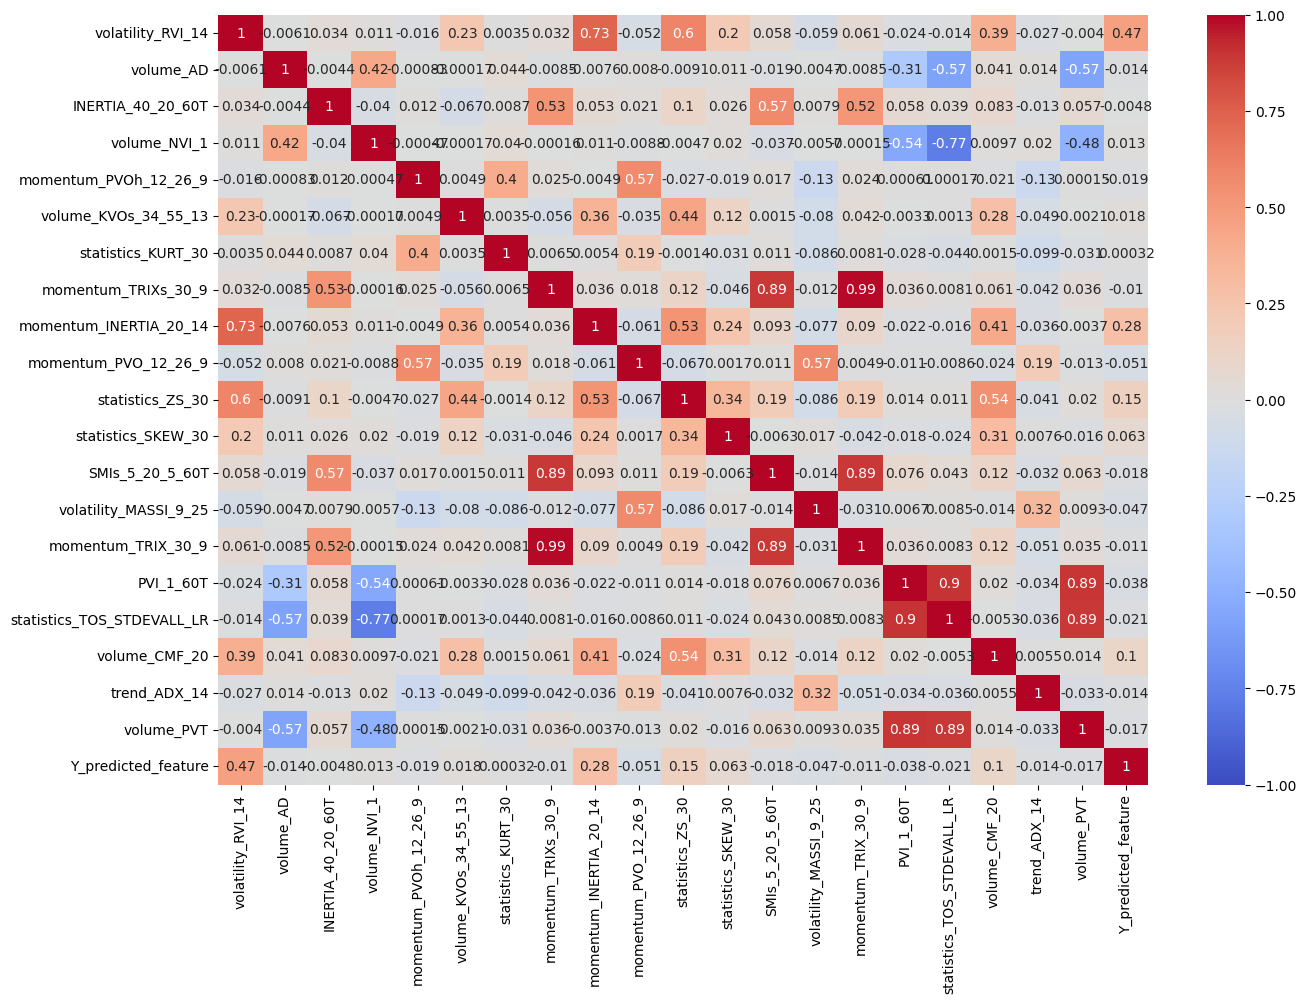

In [41]:
## plot correlation for 20 most important features
X_temp = pd.concat([X_train[pd.Series(model.feature_importance(), X_train.columns).sort_values(ascending=False).head(20).index.values].copy(), y_train.rename("Y_predicted_feature")], axis=1)

# Compute correlations
corr = X_temp.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# PREDICTIONS Result

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier


Accuracy: 0.35
Precision: 0.54
Recall: 0.30
F1 Score: 0.32
ROC AUC: 0.77


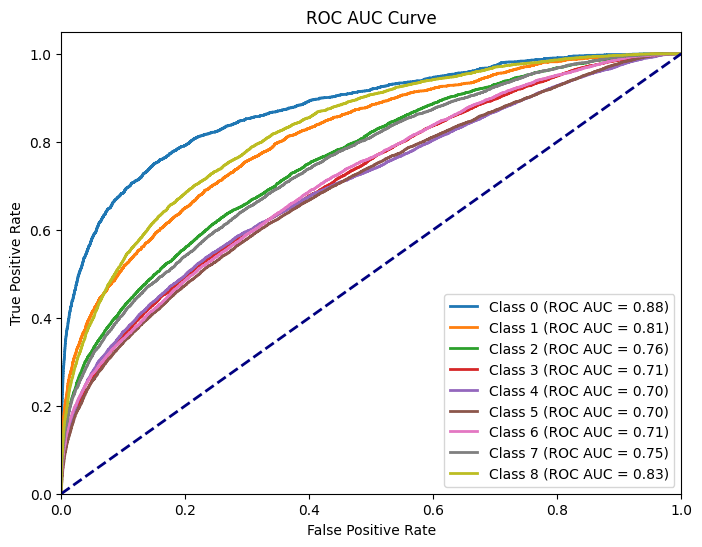

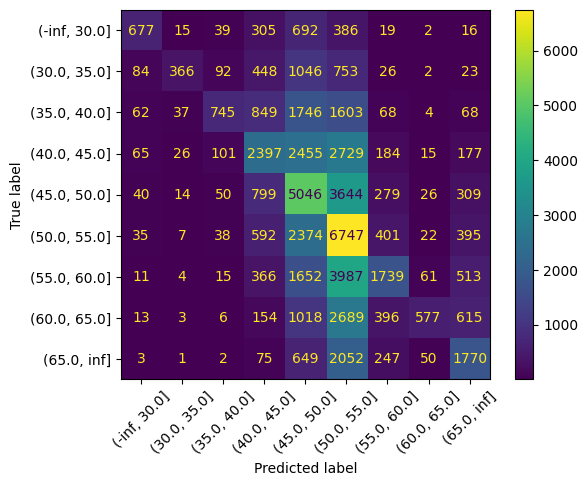

In [43]:
# make predictions on the train set

# Make predictions on the test set
y_pred = model.predict(X_train)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_train, y_pred.argmax(axis=1))
precision = precision_score(y_train, y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_train, y_pred.argmax(axis=1), average='macro')
f1 = f1_score(y_train, y_pred.argmax(axis=1), average='macro')
roc_auc = roc_auc_score(y_train, y_pred, multi_class='ovo')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC AUC curves for each class (for multiclass)
plt.figure(figsize=(8, 6))
for i in range(y_pred.shape[1]):
    fpr, tpr, _ = roc_curve(y_train, y_pred[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()

# print confusion matrix with column labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

Accuracy: 0.21
Precision: 0.21
Recall: 0.17
F1 Score: 0.16
ROC AUC: 0.67


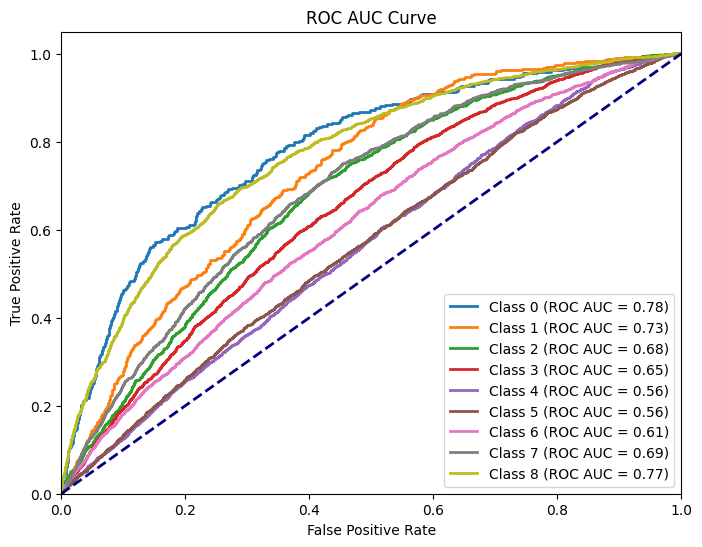

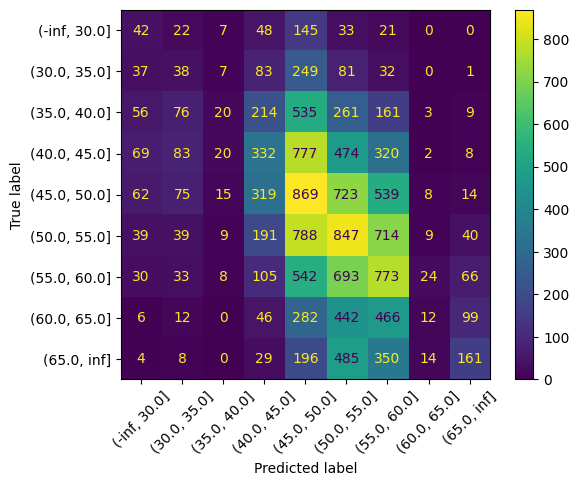

In [44]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
precision = precision_score(y_test, y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test, y_pred.argmax(axis=1), average='macro')
f1 = f1_score(y_test, y_pred.argmax(axis=1), average='macro')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC AUC curves for each class (for multiclass)
plt.figure(figsize=(8, 6))
for i in range(y_pred.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


# print confusion matrix with column labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

Accuracy: 0.22
Precision: 0.22
Recall: 0.16
F1 Score: 0.16
ROC AUC: 0.68


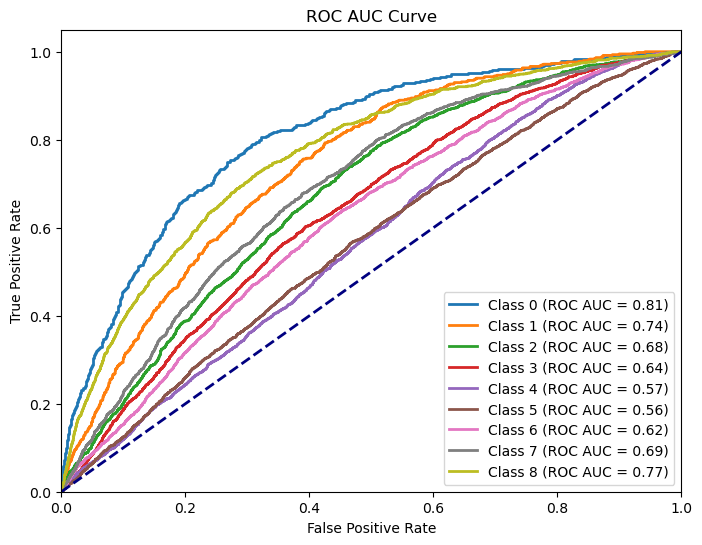

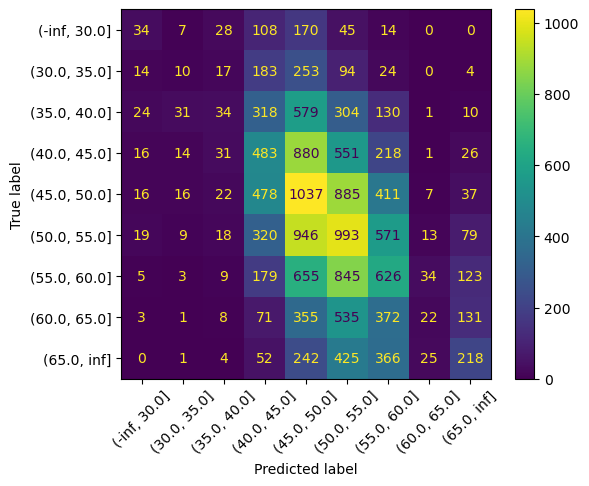

In [141]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
precision = precision_score(y_test, y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test, y_pred.argmax(axis=1), average='macro')
f1 = f1_score(y_test, y_pred.argmax(axis=1), average='macro')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC AUC curves for each class (for multiclass)
plt.figure(figsize=(8, 6))
for i in range(y_pred.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


# print confusion matrix with column labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

Accuracy: 0.21
Precision: 0.20
Recall: 0.15
F1 Score: 0.15
ROC AUC: 0.68


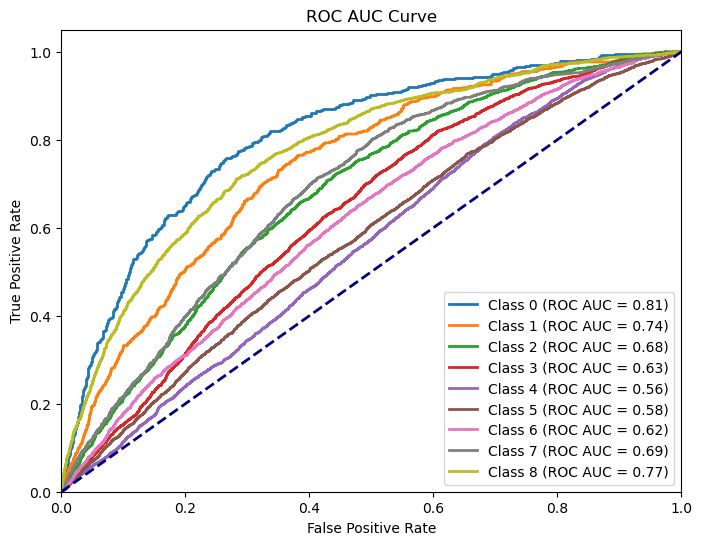

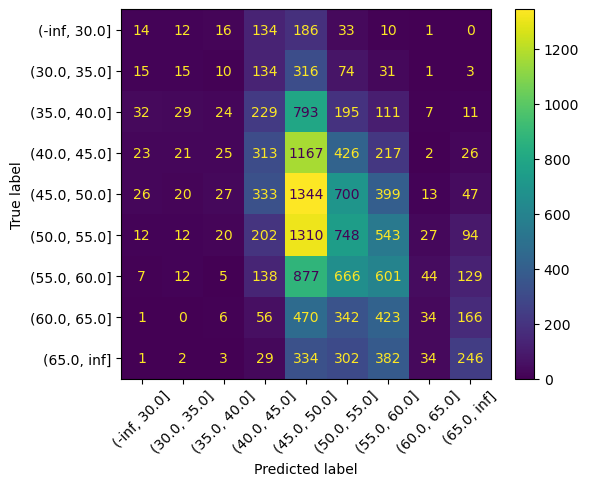

In [149]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
precision = precision_score(y_test, y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test, y_pred.argmax(axis=1), average='macro')
f1 = f1_score(y_test, y_pred.argmax(axis=1), average='macro')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC AUC curves for each class (for multiclass)
plt.figure(figsize=(8, 6))
for i in range(y_pred.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


# print confusion matrix with column labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

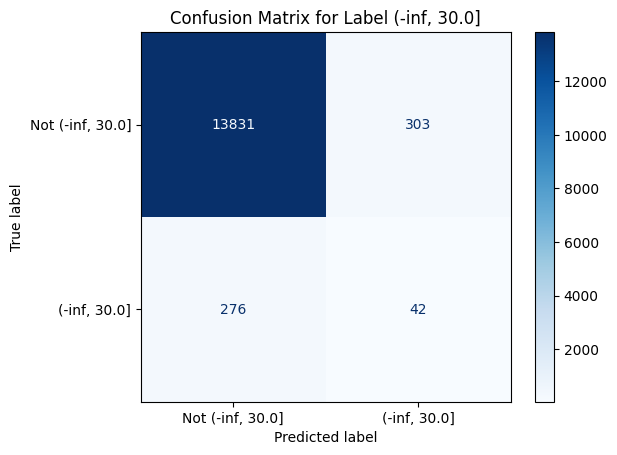

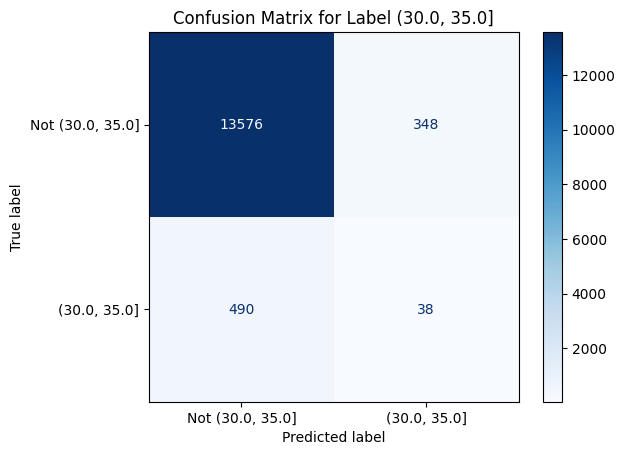

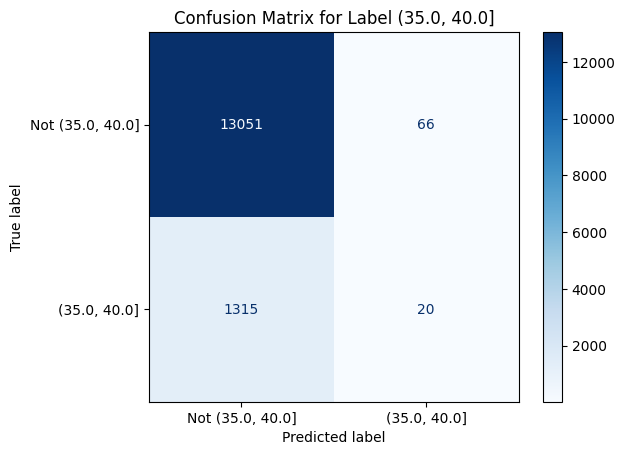

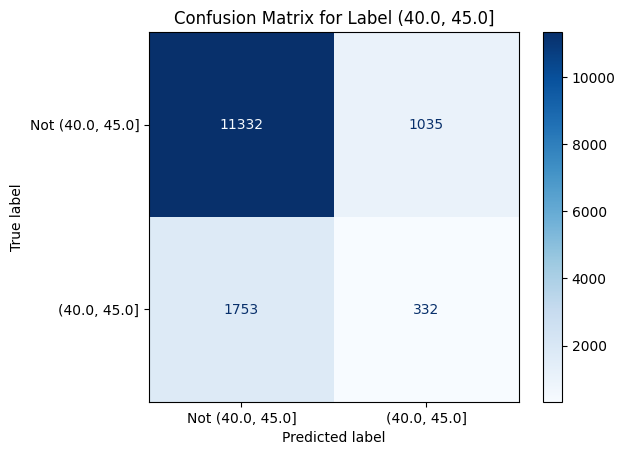

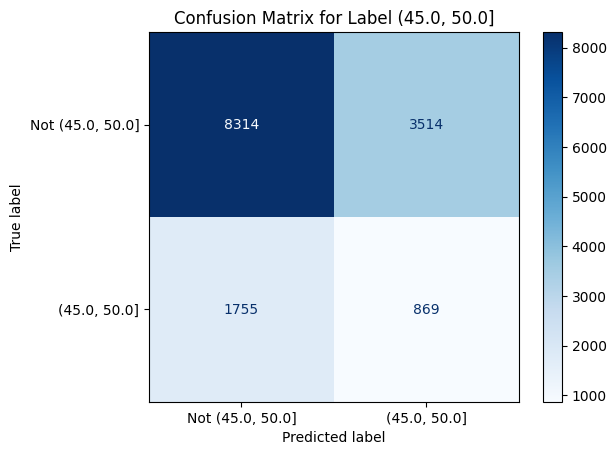

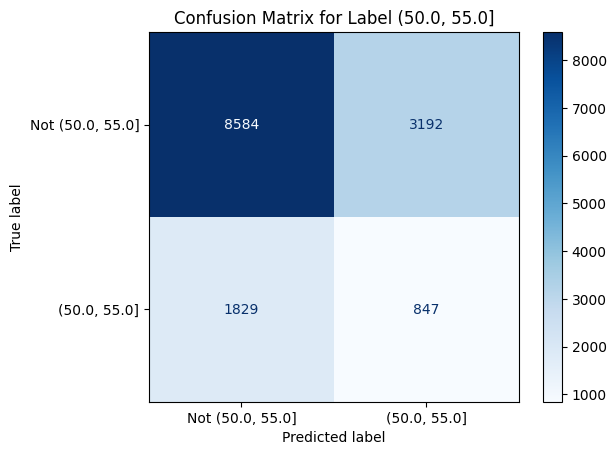

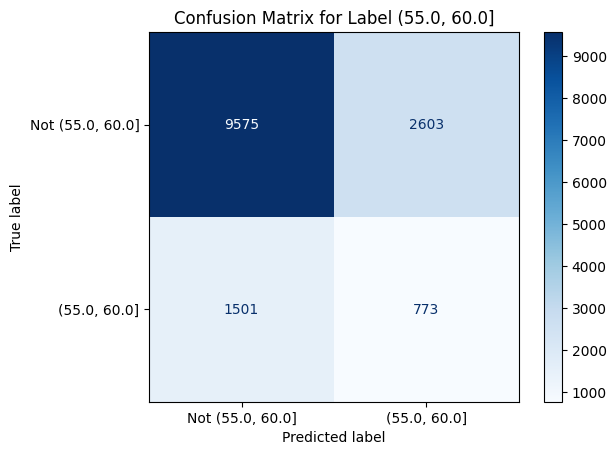

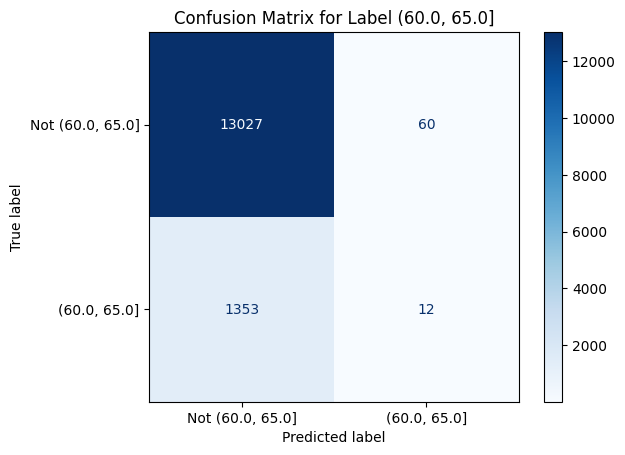

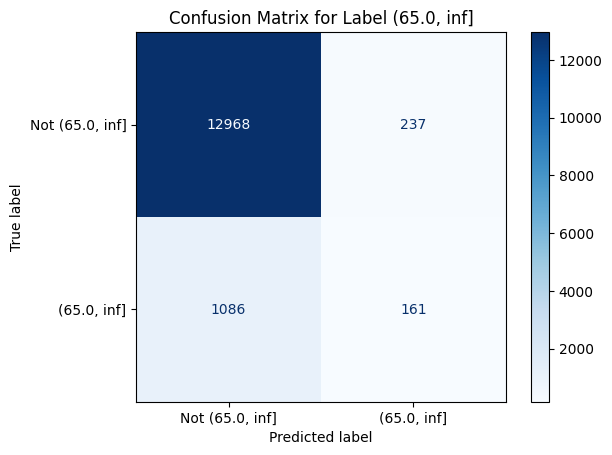

In [45]:
num_labels = len(y_labels)
labels = range(num_labels)  # Assuming labels are 0, 1, ..., 7
threshold = 0.2
for i, label in enumerate(y_labels):
    # Consider current label as positive and all others as negative
    binarized_true = np.where(y_test == i, 1, 0)
    binarized_pred = np.where(np.argmax(y_pred, axis=1) == i, 1, 0)
    # binarized_pred = np.where(y_pred[:, i] > threshold, 1, 0)

    # Compute confusion matrix for the current label
    conf_matrix = confusion_matrix(binarized_true, binarized_pred)

    # Display confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f'Not {label}', label])
    
    disp.plot(cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix for Label {label}')
    plt.show()

## Visualization

In [124]:
from finance_visualization_utils import candlestick_plot, add_trade_trace, add_indicator_curves

In [125]:
fig = candlestick_plot(X.loc[X_test.index])

In [127]:
label = 8
mask_label = np.argmax(y_pred, axis=1)==label
mask_label_true = mask_label & (y_test==label).values
add_trade_trace(fig, X.loc[X_test.index][mask_label].reset_index().rename(columns={'Timestamp':'EntryTime'}).assign(EntryPrice=lambda x: x[['Open', 'Close']].max(axis=1))
                      , f'({mask_label.sum()}) {y_labels[label]} predictions', color='black')

add_trade_trace(fig, X.loc[X_test.index][mask_label_true].reset_index().rename(columns={'Timestamp':'EntryTime'}).assign(EntryPrice=lambda x: x[['Open', 'Close']].max(axis=1))
                      , f'({mask_label_true.sum()}) {y_labels[label]} true predictions', color='cyan')

In [ ]:
fig.write_html('candlestick_plot.html', auto_open=True)